# ML for climate and Energy (MEC51057)
# Group project: Weather station

**Mentor**:
- Julio 

**Students**:
- Dimitri Iratchet
- Fabien Lagnieu
- Tristan Waddington

## 1. Data loading

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime


The variables in this data set are the raw variables that you can find in the ERA reanalysis

| Variable name  | Description                             | Unit    |
| :------------- | :-------------                          | :------ |
| t2m            | Air temperature at 2 m above the ground | [K]     |
| d2m            | [Dew point](https://en.wikipedia.org/wiki/Dew_point) at 2 m above the ground       | [K]     |
| u10            | Zonal wind component at 10 m            | [m/s]   |
| v10            | Meridional wind component at 10 m       | [m/s]   |
| skt            | Skin temperature                        | [K]     |
| tcc            | Total cloud cover                       | [0-1]   |
| sp             | Surface pressure                        | [Pa]    |
| tp             | Total precipitation                     | [m]     |
| ssrd           | Surface solar radiation (downwards)     | [J/m^2] |
| blh            | Boundary layer height                   | [m]     |


In [2]:
var_legend = {
    "t2m": "Air temperature at 2 m above the ground [K]",
    "d2m": "Dew point at 2 m above the ground [K]",
    "u10": "Zonal wind component at 10 m [m/s]",
    "v10": "Meridional wind component at 10 m [m/s]",
    "skt": "Skin temperature [K]",
    "tcc": "Total cloud cover [0-1]",
    "sp": "Surface pressure [Pa]",
    "tp": "Total precipitation [m]",
    "ssrd": "Surface solar radiation (downwards) [J/m^2]",
    "blh": "Boundary layer height [m]",
}

### 1.1 File control

In [3]:
base_path: Path = Path("data", "weather_data")

In [4]:
# Control the content of the datafiles
for subfolder in base_path.iterdir():
    # subfolder_path = os.path.join(base_path, subfolder)
    if not subfolder.is_dir():
        continue
    print(f"========== {subfolder.name.capitalize()} weather station data ===========")
    print("File Name\tStart date       ->End date\t\tstep\tnb values")
    for file_name in subfolder.iterdir():
        if file_name.suffix != ".nc":
            continue
        ds = xr.open_dataset(file_name)
        # display a global summary
        first_timstep = ds.time[0].dt.strftime("%Y %b %d %H:%M").item()
        last_timstep = ds.time[-1].dt.strftime("%Y %b %d %H:%M").item()
        timestep = (ds.time[1] - ds.time[0]).dt.seconds.item() / 3600
        total_values = ds.sizes["time"]

        print(
            f"File {file_name},\t{first_timstep}->{last_timstep}\t"
            f"{timestep}h\t{total_values}"
        )

========== Paris weather station data ===========
File Name	Start date       ->End date		step	nb values
File data/weather_data/paris/blh.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/t2m.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/tcc.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/u10.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/skt.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/d2m.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/v10.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
File data/weather_data/paris/tp.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/ssrd.nc,	1980 Jan 01 07:00->2021 Jan 01 06:00	1.0h	359424
File data/weather_data/paris/sp.nc,	1980 Jan 01 00:00->2020 Dec 31 23:00	1.0h	359424
========== Marseille weather station 

### 1.2 Load into Pandas DataFrame

In [5]:
# Load the data by City
def load_nc_files_by_subfolders(base_path: Path) -> pd.DataFrame:
    """Load weather data as a dict of DataFrame by city containing all variables."""
    dataframes: dict[pd.DataFrame] = {}
    for subfolder in base_path.iterdir():
        # subfolder_path = os.path.join(base_path, subfolder)
        if not subfolder.is_dir():
            continue
        combined_ds = None
        for file in subfolder.iterdir():
            if file.suffix != ".nc":
                continue
            # file_path = os.path.join(subfolder_path, file)
            ds = xr.load_dataset(file)
            # ds = ds.rename({var: f"{file.split('.')[0]}_{var}" for var in ds.data_vars})
            if combined_ds is None:
                combined_ds = ds
            else:
                combined_ds = xr.concat([combined_ds, ds], dim="time")
        if combined_ds is not None:
            dataframes[subfolder.name] = combined_ds.to_dataframe()
    return dataframes


weather_stations: dict[pd.DataFrame] = load_nc_files_by_subfolders(base_path)

In [6]:
# Load the data by City
def load_nc_files_by_subfolders(base_path: Path) -> dict[str, pd.DataFrame]:
    """Load weather data as a dict of DataFrame by city containing all variables."""
    dataframes: dict[str, pd.DataFrame] = {}
    for subfolder in base_path.iterdir():
        if not subfolder.is_dir():
            continue
        nc_files = list(subfolder.glob("*.nc"))
        if not nc_files:
            continue
        combined_ds = xr.open_mfdataset(nc_files, combine="by_coords")
        combined_ds = combined_ds.dropna(
            dim="time", how="all"
        )  # Drop NaN values along the time dimension
        dataframes[subfolder.name] = (
            combined_ds.to_dataframe().dropna()
        )  # Drop remaining NaN values
    return dataframes


weather_stations = load_nc_files_by_subfolders(base_path)

In [7]:
cities: list[str] = list(weather_stations.keys())
print(cities)

['paris', 'marseille', 'brest', 'london', 'berlin']


In [8]:
weather_stations["paris"].describe()

,blh,d2m,skt,sp,ssrd,t2m,tcc,tp,u10,v10
count,359417.000000,359417.000000,359417.000000,359417.000000,3.594170e+05,359417.000000,359417.000000,359417.000000,359417.000000,359417.000000
mean,604.317078,280.462860,284.343781,100415.406250,4.776419e+05,284.404419,0.664972,0.000082,0.864810,0.351663
std,470.653076,5.681643,7.730831,906.632751,7.350288e+05,7.121730,0.369240,0.000297,2.641548,2.879296
min,9.829140,254.678604,252.089996,94526.585938,-1.901566e+00,256.771332,0.000000,0.000000,-9.424118,-10.220169
25%,205.057785,276.560394,278.848663,99890.265625,0.000000e+00,279.367126,0.347229,0.000000,-1.184723,-1.833115
50%,492.641144,280.908813,283.880432,100472.210938,2.099200e+04,284.210480,0.842041,0.000000,0.842026,0.232529
75%,915.958130,284.717346,289.336578,101001.015625,7.504640e+05,289.264130,0.998413,0.000009,2.671127,2.403152
max,3572.631348,295.901764,317.110504,103395.062500,3.315712e+06,314.154785,1.000000,0.011550,16.235458,14.881912


> The data is not normalized. This could be an issue during the training.


In [9]:
weather_stations["paris"].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 359417 entries, (48.75, 2.25, Timestamp('1980-01-01 07:00:00')) to (48.75, 2.25, Timestamp('2020-12-31 23:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   blh     359417 non-null  float32
 1   d2m     359417 non-null  float32
 2   skt     359417 non-null  float32
 3   sp      359417 non-null  float32
 4   ssrd    359417 non-null  float32
 5   t2m     359417 non-null  float32
 6   tcc     359417 non-null  float32
 7   tp      359417 non-null  float32
 8   u10     359417 non-null  float32
 9   v10     359417 non-null  float32
dtypes: float32(10)
memory usage: 26.6 MB


> The DataFrame is loaded with a multi-index. We will delete it to access to the descriptioon of the data.

#### Extract the city coordinates for later use

In [10]:
weather_stations["paris"].index[0][1:]

cities_latlon: dict[tuple[float]] = {
    city: weather_stations[city].index[0][:2] for city in cities
}
print(cities_latlon)

{'paris': (48.75, 2.25), 'marseille': (43.25, 5.5), 'brest': (48.5, 355.5), 'london': (51.5, 359.75), 'berlin': (52.5, 13.5)}


### Plot on a map
with `cartopy` https://scitools.org.uk/cartopy/docs/latest/gallery/lines_and_polygons/features.html#sphx-glr-gallery-lines-and-polygons-features-py

This will download the background on first use.

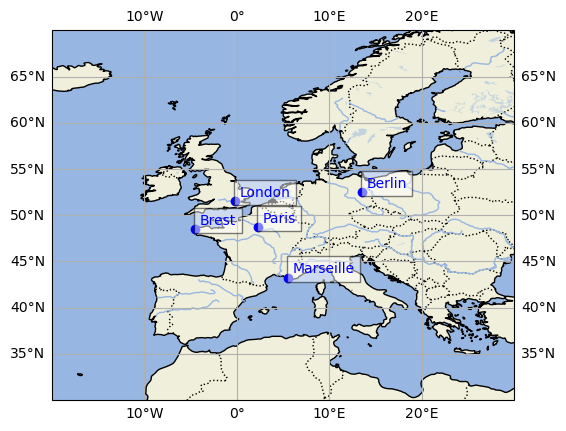

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 30, 70], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True)
for city, (lat, lon) in cities_latlon.items():
    ax.text(
        lon + 0.5,
        lat + 0.5,
        city.capitalize(),
        bbox=dict(facecolor="white", alpha=0.5),
        color="b",
        transform=ccrs.PlateCarree(),
    )
    ax.plot(lon, lat, "bo", transform=ccrs.PlateCarree())
ax.plot()
plt.show()

#### Data cleaning

In [12]:
for city in weather_stations.keys():
    # Delete the multiindex
    weather_stations[city].reset_index(
        level=["latitude", "longitude"], drop=True, inplace=True
    )

In [13]:
# Get the minimum and maximum time for each dataset
min_times = [df.index.min() for df in weather_stations.values()]
max_times = [df.index.max() for df in weather_stations.values()]

# Determine the common timeframe
common_min_time = max(min_times)
common_max_time = min(max_times)
print(f"Common timeframe: {common_min_time} to {common_max_time}")

# Filter each dataset to keep only the common timeframe
for city in weather_stations:
    weather_stations[city] = weather_stations[city].loc[common_min_time:common_max_time]


Common timeframe: 1980-01-01 07:00:00 to 2019-12-31 23:00:00


### 1.3 Split the datasets

In [14]:
split_date = "01-01-2016"

In [15]:
# Create a dictionary to hold the datasets for each variable
variable_datasets_X = {}
variable_datasets_y = {}

# Get the list of variables from one of the city's dataset
variables = weather_stations[cities[0]].columns

# Iterate over each variable
for variable in variables:
    # Create a DataFrame for the current variable
    variable_df_X = pd.DataFrame()
    variable_df_y = pd.DataFrame()

    # Iterate over each city and add the variable data to the DataFrame
    for city in cities:
        if city == "paris":
            variable_df_y[city] = weather_stations[city][variable]
        else:
            variable_df_X[city] = weather_stations[city][variable]

    # Add the DataFrame to the dictionary
    variable_datasets_X[variable] = variable_df_X
    variable_datasets_y[variable] = variable_df_y

# Print the keys of the dictionary to verify
print(variable_datasets_X.keys())

dict_keys(['blh', 'd2m', 'skt', 'sp', 'ssrd', 't2m', 'tcc', 'tp', 'u10', 'v10'])


In [16]:
variable_datasets_X["blh"]

,marseille,brest,london,berlin
time,,,,
1980-01-01 07:00:00,387.289490,278.789490,116.914497,502.789490
1980-01-01 08:00:00,382.825958,263.075958,126.200958,487.700958
1980-01-01 09:00:00,419.158630,258.783630,144.283615,511.283630
1980-01-01 10:00:00,528.698120,316.948090,187.573105,498.823090
1980-01-01 11:00:00,644.350281,348.975311,242.350311,476.975311
...,...,...,...,...
2019-12-31 19:00:00,288.035522,272.035522,487.660522,598.160522
2019-12-31 20:00:00,299.279602,237.779587,492.029602,502.529602
2019-12-31 21:00:00,284.007660,213.132645,475.382660,455.757660


In [17]:
# Convert split_date to a pandas datetime object
split_date = pd.to_datetime(split_date, format="%d-%m-%Y")

# Create dictionaries to hold the train and test datasets for each variable
variable_datasets_X_train = {}
variable_datasets_X_test = {}
variable_datasets_y_train = {}
variable_datasets_y_test = {}

# Split the datasets
for variable in variables:
    # Split the X dataset
    variable_datasets_X_train[variable] = variable_datasets_X[variable][
        variable_datasets_X[variable].index < split_date
    ]
    variable_datasets_X_test[variable] = variable_datasets_X[variable][
        variable_datasets_X[variable].index >= split_date
    ]

    # Split the y dataset
    variable_datasets_y_train[variable] = variable_datasets_y[variable][
        variable_datasets_y[variable].index < split_date
    ]
    variable_datasets_y_test[variable] = variable_datasets_y[variable][
        variable_datasets_y[variable].index >= split_date
    ]

# Print the shapes of the train and test datasets to verify
for variable in variables:
    print(
        f"{variable} - Train X: {variable_datasets_X_train[variable].shape}, Test X: {variable_datasets_X_test[variable].shape}"
    )
    print(
        f"{variable} - Train y: {variable_datasets_y_train[variable].shape}, Test y: {variable_datasets_y_test[variable].shape}"
    )

blh - Train X: (315569, 4), Test X: (35064, 4)
blh - Train y: (315569, 1), Test y: (35064, 1)
d2m - Train X: (315569, 4), Test X: (35064, 4)
d2m - Train y: (315569, 1), Test y: (35064, 1)
skt - Train X: (315569, 4), Test X: (35064, 4)
skt - Train y: (315569, 1), Test y: (35064, 1)
sp - Train X: (315569, 4), Test X: (35064, 4)
sp - Train y: (315569, 1), Test y: (35064, 1)
ssrd - Train X: (315569, 4), Test X: (35064, 4)
ssrd - Train y: (315569, 1), Test y: (35064, 1)
t2m - Train X: (315569, 4), Test X: (35064, 4)
t2m - Train y: (315569, 1), Test y: (35064, 1)
tcc - Train X: (315569, 4), Test X: (35064, 4)
tcc - Train y: (315569, 1), Test y: (35064, 1)
tp - Train X: (315569, 4), Test X: (35064, 4)
tp - Train y: (315569, 1), Test y: (35064, 1)
u10 - Train X: (315569, 4), Test X: (35064, 4)
u10 - Train y: (315569, 1), Test y: (35064, 1)
v10 - Train X: (315569, 4), Test X: (35064, 4)
v10 - Train y: (315569, 1), Test y: (35064, 1)


In [18]:
from sklearn.preprocessing import StandardScaler

# Normalize each dataset
scalers_X = {}
scalers_y = {}

for variable in variables:
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Normalize the train X dataset
    variable_datasets_X_train[variable] = pd.DataFrame(
        scaler_X.fit_transform(variable_datasets_X_train[variable]),
        index=variable_datasets_X_train[variable].index,
        columns=variable_datasets_X_train[variable].columns,
    )

    # Normalize the test X dataset using the same scaler
    variable_datasets_X_test[variable] = pd.DataFrame(
        scaler_X.transform(variable_datasets_X_test[variable]),
        index=variable_datasets_X_test[variable].index,
        columns=variable_datasets_X_test[variable].columns,
    )

    # Normalize the train y dataset
    variable_datasets_y_train[variable] = pd.DataFrame(
        scaler_y.fit_transform(variable_datasets_y_train[variable]),
        index=variable_datasets_y_train[variable].index,
        columns=variable_datasets_y_train[variable].columns,
    )

    # Normalize the test y dataset using the same scaler
    variable_datasets_y_test[variable] = pd.DataFrame(
        scaler_y.transform(variable_datasets_y_test[variable]),
        index=variable_datasets_y_test[variable].index,
        columns=variable_datasets_y_test[variable].columns,
    )

    scalers_X[variable] = scaler_X
    scalers_y[variable] = scaler_y

In [19]:
variable_datasets_y_train["skt"].describe()

,paris
count,3.155690e+05
mean,3.868261e-10
std,9.999595e-01
min,-4.190093e+00
25%,-7.098190e-01
50%,-5.086245e-02
75%,6.487415e-01
max,4.024086e+00


In [20]:
# Save variable_datasets_X_train to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_X_train.h5") as store:
    for variable, df in variable_datasets_X_train.items():
        store.put(variable, df)

# Save variable_datasets_X_test to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_X_test.h5") as store:
    for variable, df in variable_datasets_X_test.items():
        store.put(variable, df)

# Save variable_datasets_y_train to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_y_train.h5") as store:
    for variable, df in variable_datasets_y_train.items():
        store.put(variable, df)

# Save variable_datasets_y_test to HDF5
with pd.HDFStore("data/norm_data/variable_datasets_y_test.h5") as store:
    for variable, df in variable_datasets_y_test.items():
        store.put(variable, df)

In [21]:
def load_normalize_data():
    """Load the previous prepared normalized dataset
    returns: X_train, X_test, y_train, Y_test"""
    # Load variable_datasets_X_train from HDF5
    variable_datasets_X_train = {}
    with pd.HDFStore("data/norm_data/variable_datasets_X_train.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_X_train[variable_name] = store[variable]

    # Load variable_datasets_X_test from HDF5
    variable_datasets_X_test = {}
    with pd.HDFStore("data/norm_data/variable_datasets_X_test.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_X_test[variable_name] = store[variable]

    # Load variable_datasets_y_train from HDF5
    variable_datasets_y_train = {}
    with pd.HDFStore("data/norm_data/variable_datasets_y_train.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_y_train[variable_name] = store[variable]

    # Load variable_datasets_y_test from HDF5
    variable_datasets_y_test = {}
    with pd.HDFStore("data/norm_data/variable_datasets_y_test.h5") as store:
        for variable in store.keys():
            variable_name = variable.strip("/")
            variable_datasets_y_test[variable_name] = store[variable]

    return (
        variable_datasets_X_train,
        variable_datasets_X_test,
        variable_datasets_y_train,
        variable_datasets_y_test,
    )

### 1.4 Reduce dataset

We will reduce the study dataset to reduce the computational cost during the training.
We will keep only the 13 last years (train: 2007-2015, test: 2016-2018, validation: 2019), and reduce to a daily sample.
Finally, all datasest will be merged in a single dataFrame then splitted by year of expected size:
- X_train_red : 10 * 365 rows x 4 * 10 columns
- X_test_red : 3 * 365 rows x 4 * 10 columns
- y_train_red : 10 * 365 rows x 1 * 10 columns
- y_test_red : 3 * 365 rows x 1 * 10 columns
- X_val_red : 1 * 365 rows x 4 * 10 columns
- y_val_red : 1 * 365 rows x 1 * 10 columns


This data will not be normalized at first to favorize explanation.

In [ ]:
X_red = []
Y_red = []
for x_city in ["paris", "marseille", "brest", "london", "berlin"]:
    col_names_city = [
        x_city + "_" + col_name for col_name in weather_stations[x_city].columns
    ]
    # Keep only 13 years of data
    df = weather_stations[x_city].loc[
        (weather_stations[x_city].index.year >= 2007)
        & (weather_stations[x_city].index.year < 2020)
    ]
    # Resample the data to daily frequency. Two variables need to be sum over the day, the rest averaged.
    df = df.resample("D").mean()
    df["tp"] = df["tp"].resample("D").sum()  # Total precipitation over the day
    df["ssrd"] = df["ssrd"].resample("D").sum()  # Surface solar radiation over the day
    # Replace NaN values with the previous value
    df = df.ffill()
    # rename the columns to include the city name
    df.columns = col_names_city
    if x_city == "paris":
        Y_red = df
    else:
        X_red.append(df)
# Concatenate the DataFrames of X
X_red = pd.concat(X_red, axis=1)
print(f"{X_red.shape=}, {Y_red.shape=}")

X_red.shape=(4748, 40), Y_red.shape=(4748, 10)


In [ ]:
# Control
X_red.head()

,marseille_blh,marseille_d2m,marseille_skt,marseille_sp,marseille_ssrd,marseille_t2m,marseille_tcc,marseille_tp,marseille_u10,marseille_v10,...,berlin_blh,berlin_d2m,berlin_skt,berlin_sp,berlin_ssrd,berlin_t2m,berlin_tcc,berlin_tp,berlin_u10,berlin_v10
time,,,,,,,,,,,,,,,,,,,,,
2007-01-01,400.964844,281.925568,282.885895,100524.492188,189704.00000,284.194366,0.807555,0.0,2.040620,-0.567656,...,1314.774780,277.416962,279.907867,100125.992188,111032.000000,281.234222,0.766523,0.000135,6.347383,2.735933
2007-01-02,1437.166992,274.296600,281.278351,100408.125000,312813.34375,282.685120,0.169165,0.0,6.270468,-5.100405,...,929.406555,274.998657,276.935974,100612.789062,73954.664062,277.952454,0.941760,0.000060,5.246054,1.556822
2007-01-03,522.630676,274.812775,279.874298,100480.562500,319408.00000,280.767151,0.163347,0.0,2.572366,-4.236880,...,838.682800,276.318054,277.573090,101441.273438,87704.000000,278.381989,0.903411,0.000086,4.936990,0.808164
2007-01-04,423.874634,276.699432,281.345001,99866.976562,299738.65625,281.328705,0.516071,0.0,3.351784,-2.316797,...,930.213196,277.821747,278.807098,100030.523438,36746.667969,279.842560,0.953304,0.000175,4.695778,3.925757
2007-01-05,613.923279,276.631378,281.259766,99756.187500,311690.65625,282.429657,0.346578,0.0,3.697129,-5.281730,...,1009.647278,278.254425,279.372314,100497.562500,95605.335938,280.451447,0.892190,0.000107,6.204941,0.644417


In [ ]:
# Store the data
X_red.to_csv("data/red_data/X_red.csv")
Y_red.to_csv("data/red_data/Y_red.csv")

In [ ]:
# Read the data
X_red = pd.read_csv("data/red_data/X_red.csv", index_col=0, parse_dates=True)
Y_red = pd.read_csv("data/red_data/Y_red.csv", index_col=0, parse_dates=True)

In [ ]:
def split_train_test_val(df, end_train_date: str, end_test_date: str):
    """Split the DataFrame into train, test and validation sets.
    df: DataFrame to split.
    end_train_date: (str) last date of the train set in format 'YYYY-MM-DD' excluded.
    end_test_date: (str) last date of the test set in format 'YYYY-MM-DD' excluded.
    returns: df_train, df_test, df_val.
    """
    end_test_date = pd.to_datetime(end_test_date)
    end_train_date = pd.to_datetime(end_train_date)
    assert (
        end_train_date < end_test_date
    ), "The test date should be after the train date"
    assert (
        end_test_date < df.index.max()
    ), "The test date should be before the last date"
    df_train = df.loc[df.index < end_train_date]
    df_test = df.loc[(df.index >= end_train_date) & (df.index < end_test_date)]
    df_val = df.loc[df.index >= end_test_date]
    return df_train, df_test, df_val


# Split the data into train, test and validation sets
end_train_date = "2016-01-01"
end_test_date = "2019-01-01"
X_train, X_test, X_val = split_train_test_val(X_red, end_train_date, end_test_date)
Y_train, Y_test, Y_val = split_train_test_val(Y_red, end_train_date, end_test_date)
# control the sizes
print(f"{X_train.shape=}, {X_test.shape=}, {X_val.shape=}")
print(f"{Y_train.shape=}, {Y_test.shape=}, {Y_val.shape=}")

X_train.shape=(3287, 40), X_test.shape=(1096, 40), X_val.shape=(365, 40)
Y_train.shape=(3287, 10), Y_test.shape=(1096, 10), Y_val.shape=(365, 10)


<Axes: xlabel='time'>

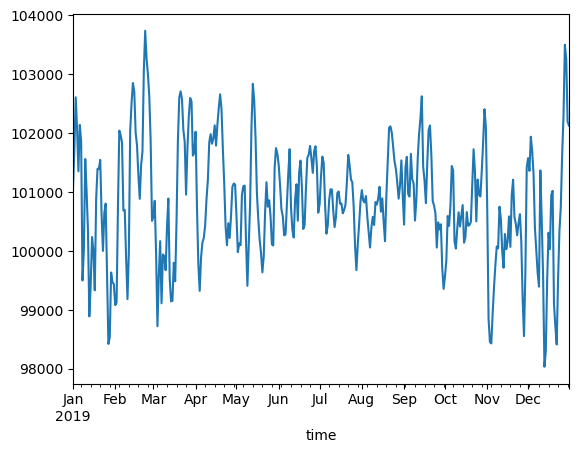

In [49]:
# control
X_val["berlin_sp"].plot()

### Nomalize the reduced data

In [ ]:
# Read the data
X_red = pd.read_csv("data/red_data/X_red.csv", index_col=0, parse_dates=True)
Y_red = pd.read_csv("data/red_data/Y_red.csv", index_col=0, parse_dates=True)

# Normalize the X, then Y with the same scaler
scaler_X = StandardScaler()


## 2. Dig into the data


<div class='alert alert-block alert-warning'>
This part uses the first loaded dataset, <b>before</b> the train/test split.
</div>


### 2.1 Cycles in the variables

In [22]:
# focus on Berlin station,
berlin_df = weather_stations["berlin"]
df = berlin_df.copy()

# Year to study
START_YEAR = 2010
END_YEAR = 2015

#### 2.1.a Seasonal

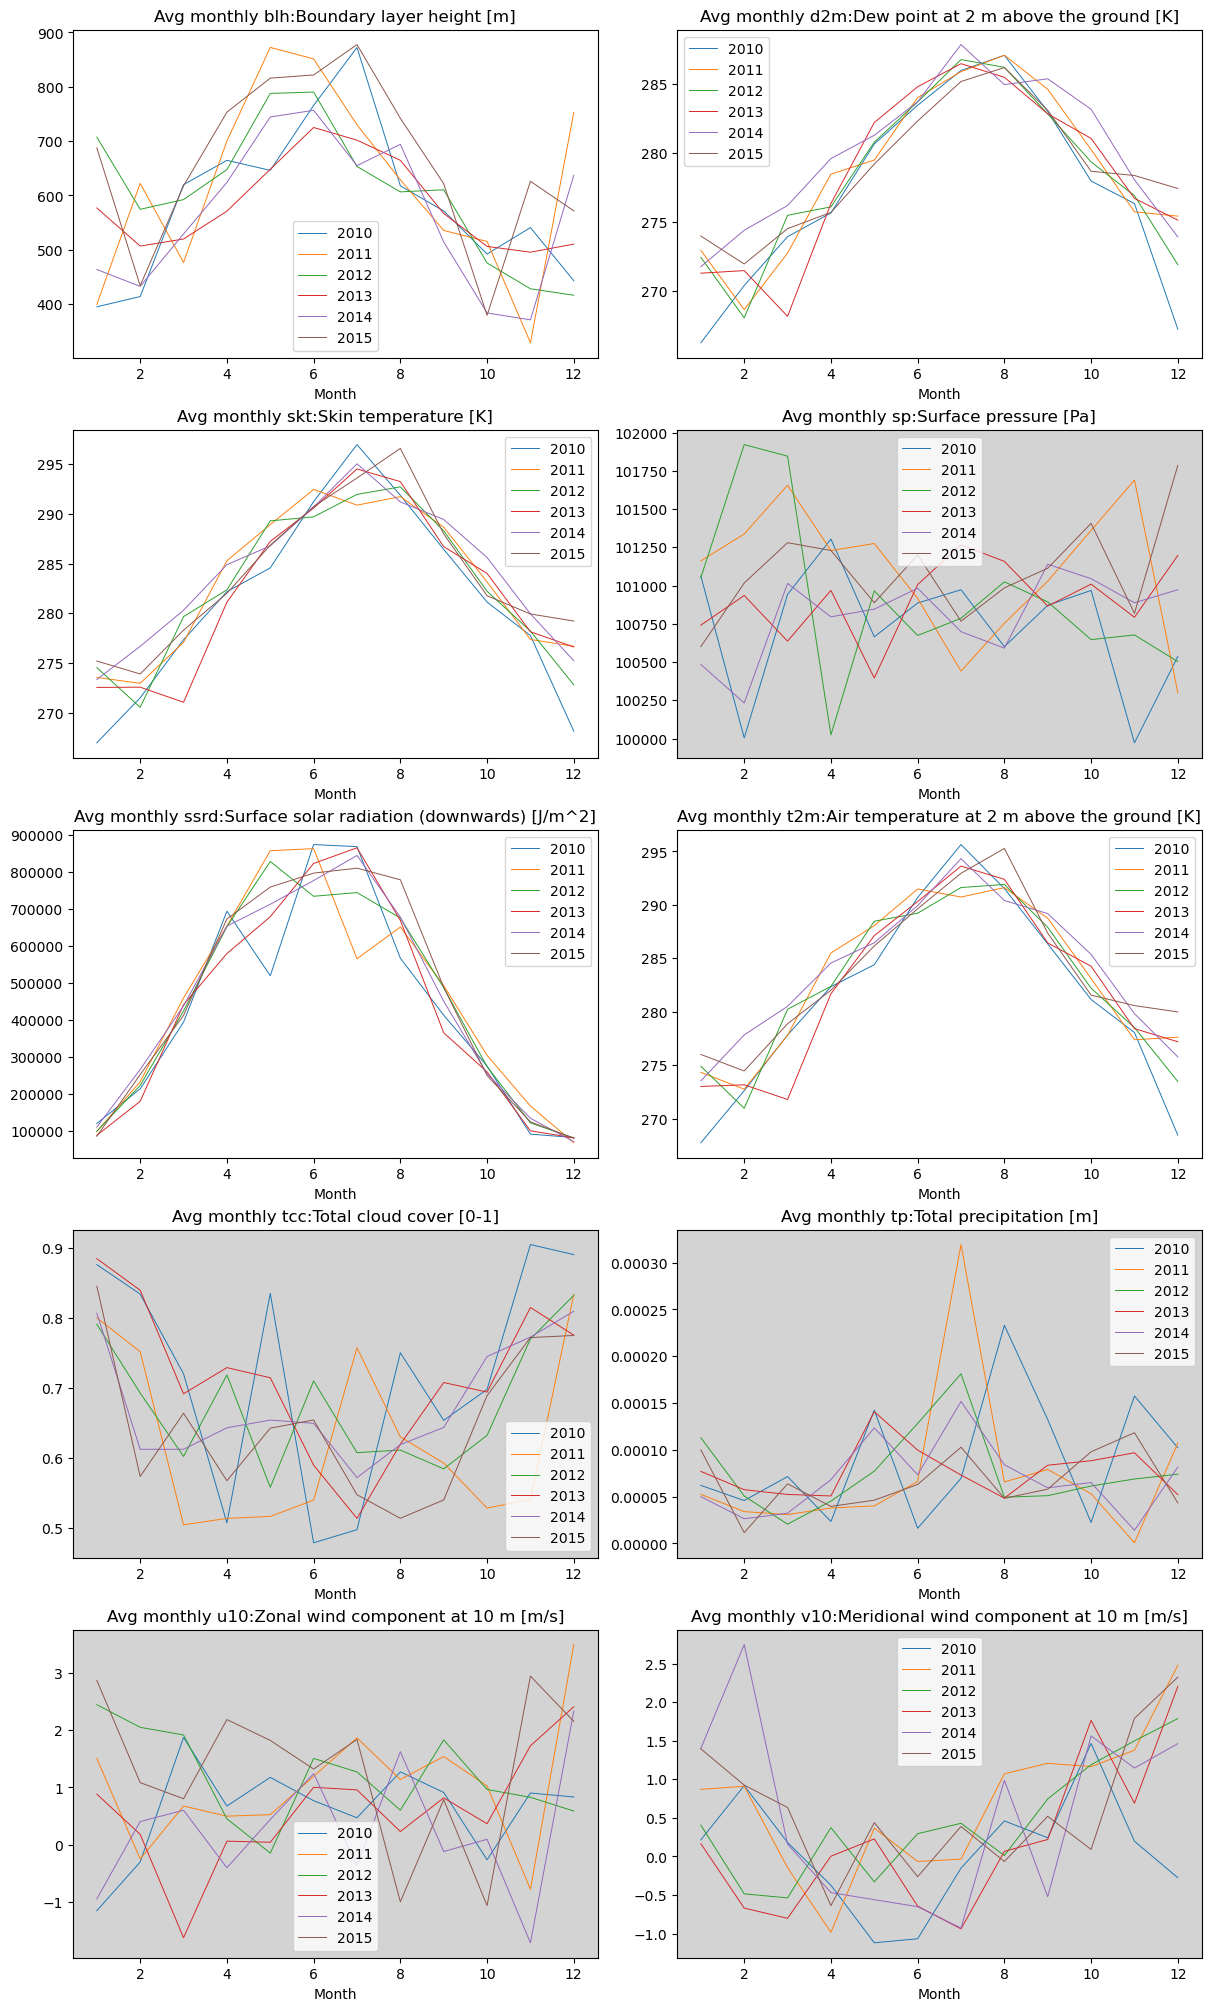

In [23]:
# Seasonal cycles
has_seasonal_cycle = {
    "t2m": True,
    "d2m": True,
    "u10": False,
    "v10": False,
    "skt": True,
    "tcc": False,
    "sp": False,
    "tp": False,
    "ssrd": True,
    "blh": True,
}
fig, axes = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axes = axes.flatten()
for year in range(START_YEAR, END_YEAR + 1):
    df_year = df[df.index.year == year]
    for name, ax in zip(df.columns, axes):
        df_year.groupby(by=df_year.index.month).mean()[name].plot(
            ax=ax, label=year, linewidth=0.7
        )
        ax.set_title(f"Avg monthly {name}:{var_legend[name]}")
        ax.set_xlabel("Month")
        ax.legend()
        # Gray out if no seasonal cycle
        if not has_seasonal_cycle[name]:
            ax.set_facecolor("lightgrey")

plt.show()

#### 2.1.b More precise seasonal experiment
This show the variability better.

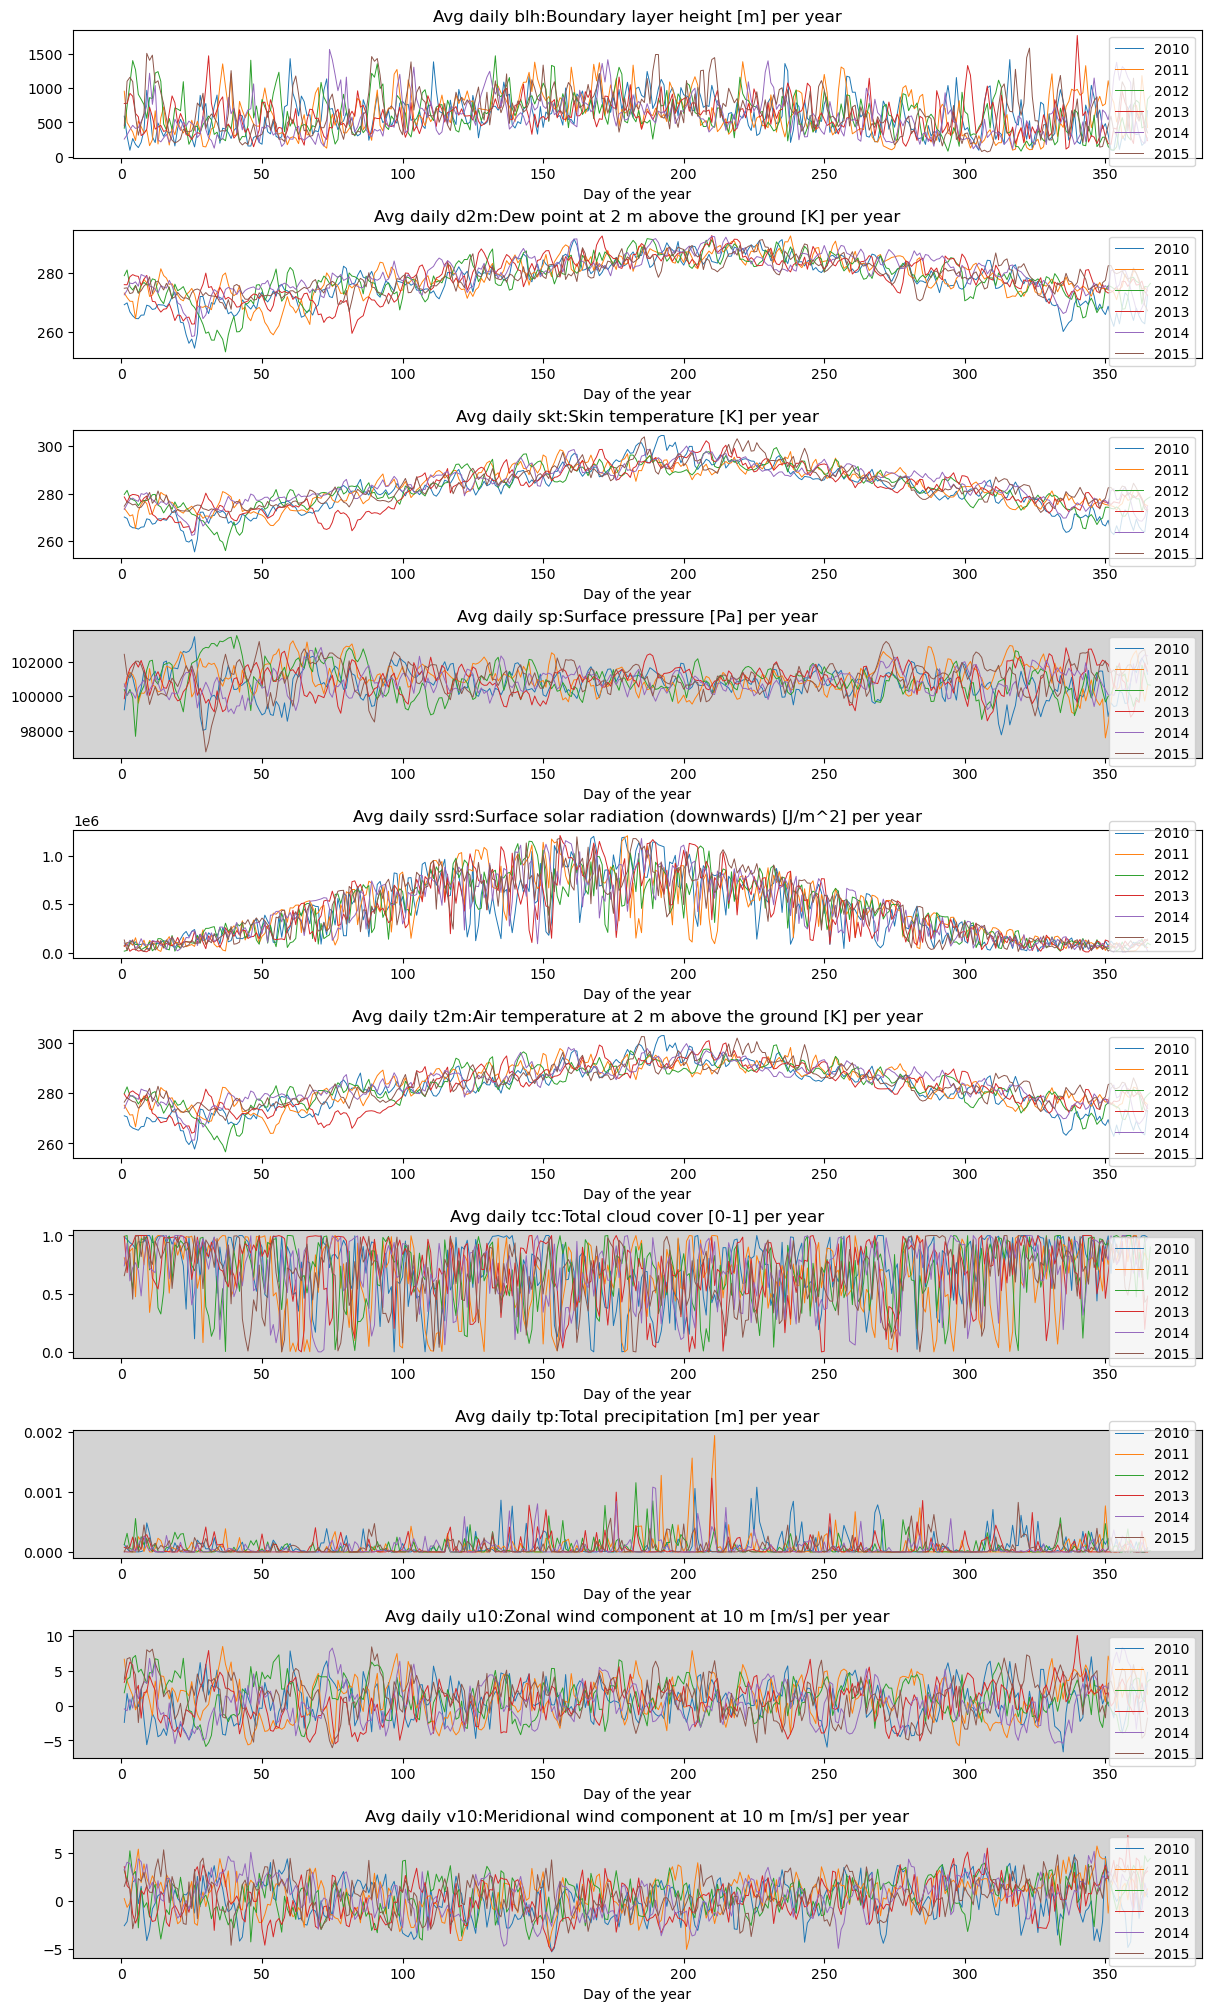

In [24]:
# Seasonal cycles
has_seasonal_cycle = {
    "t2m": True,
    "d2m": True,
    "u10": False,
    "v10": False,
    "skt": True,
    "tcc": False,
    "sp": False,
    "tp": False,
    "ssrd": True,
    "blh": True,
}
fig, axes = plt.subplots(10, 1, figsize=(12, 20), layout="constrained")
axes = axes.flatten()
for year in range(START_YEAR, END_YEAR + 1):
    df_year = df[df.index.year == year]
    for name, ax in zip(df.columns, axes):
        df_year.groupby(by=df_year.index.dayofyear).mean()[name].plot(
            ax=ax, label=year, linewidth=0.7
        )
        ax.set_title(f"Avg daily {name}:{var_legend[name]} per year")
        ax.set_xlabel("Day of the year")
        ax.legend()
        # Gray out if no seasonal cycle
        if not has_seasonal_cycle[name]:
            ax.set_facecolor("lightgrey")

plt.show()
plt.show()

#### 2.1.c Daily

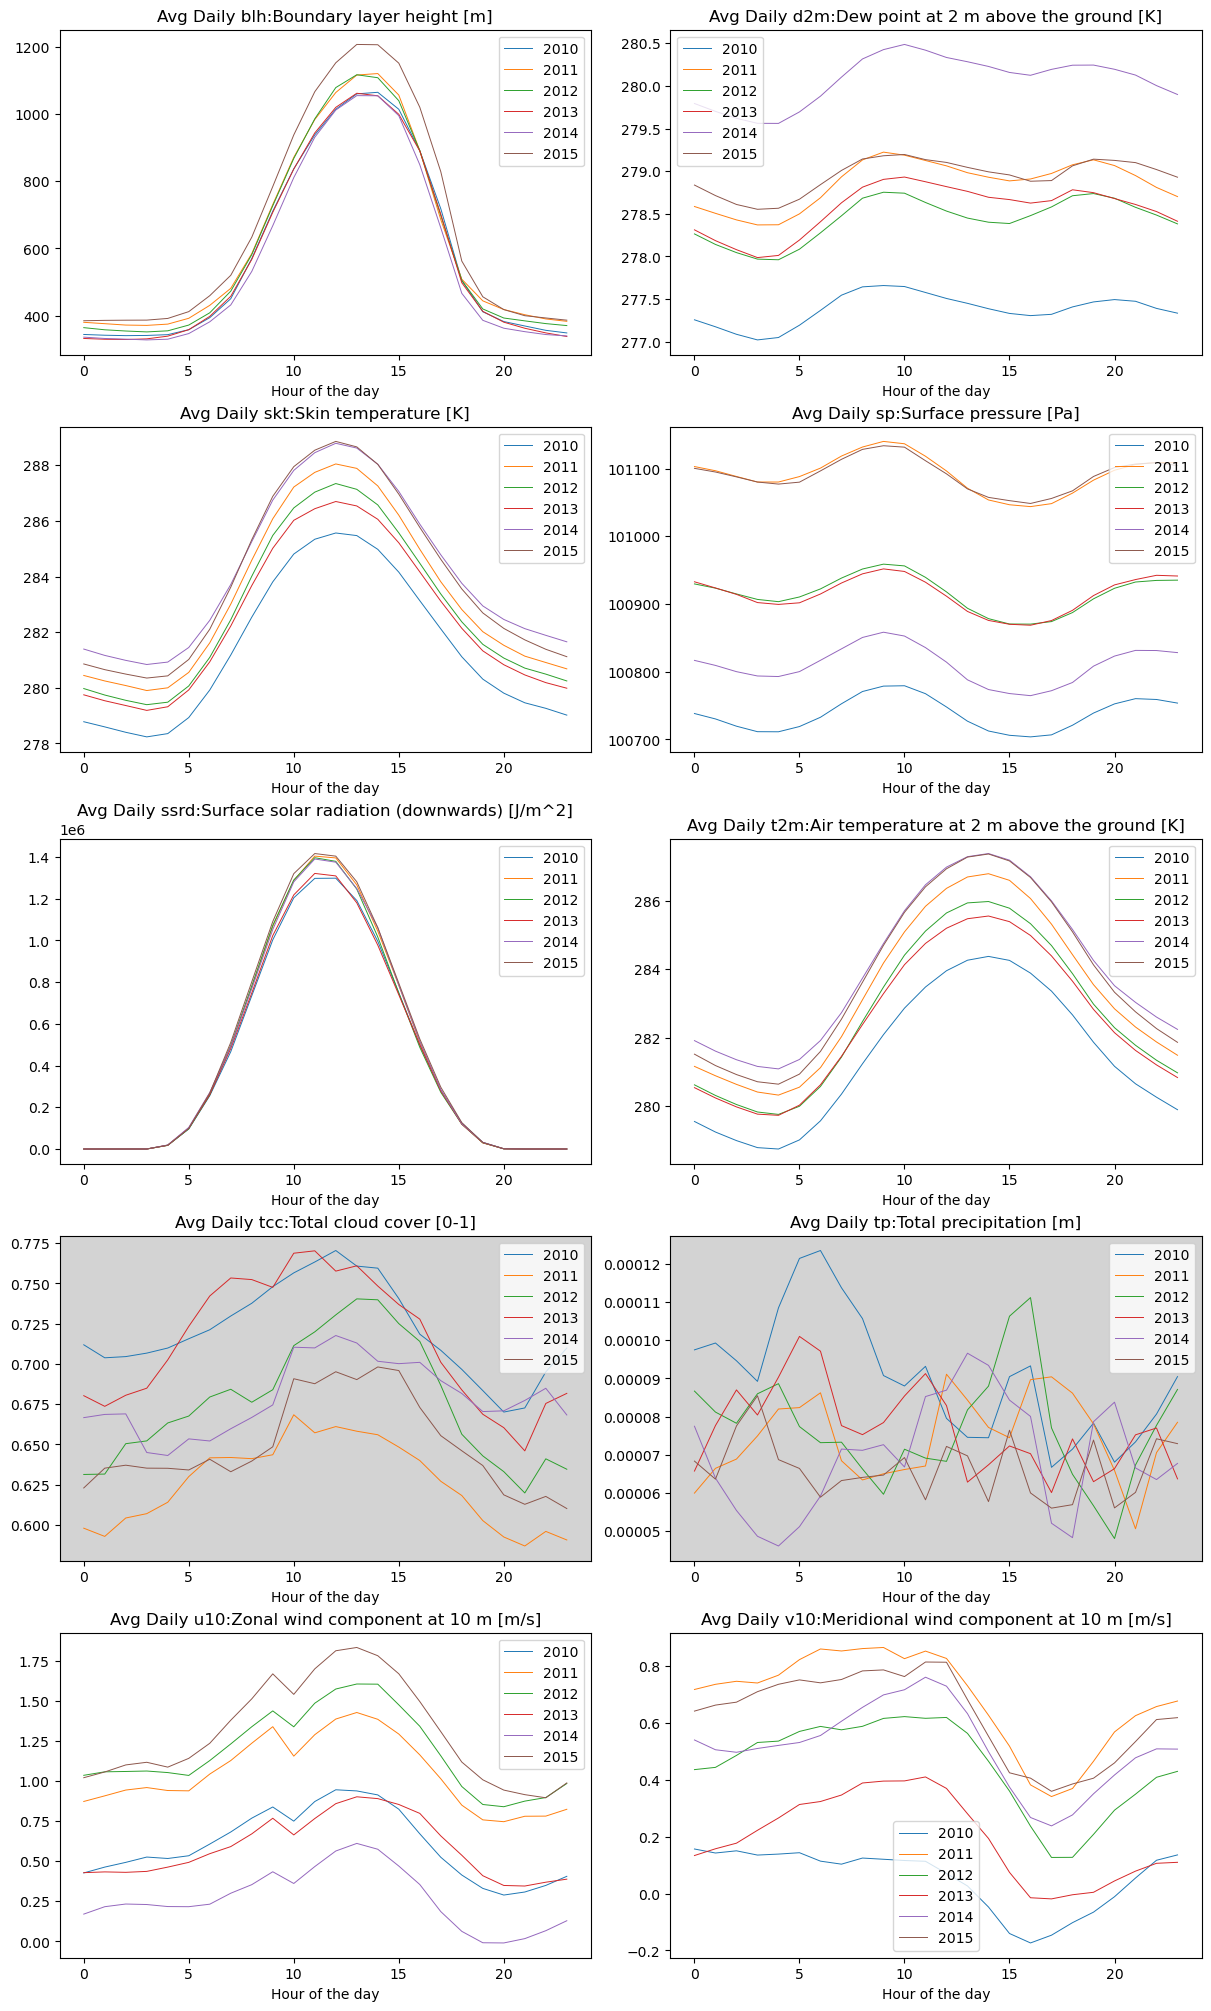

In [25]:
has_daily_cycle = {
    "t2m": True,
    "d2m": True,
    "u10": True,
    "v10": True,
    "skt": True,
    "tcc": False,
    "sp": True,
    "tp": False,
    "ssrd": True,
    "blh": True,
}
# Daily cycles
fig, axes = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axes = axes.flatten()
for year in range(START_YEAR, END_YEAR + 1):
    df_year = df[df.index.year == year]
    for name, ax in zip(df.columns, axes):
        df_year.groupby(by=df_year.index.hour).mean()[name].plot(
            ax=ax, label=year, linewidth=0.7
        )
        ax.set_title(f"Avg Daily {name}:{var_legend[name]}")
        ax.set_xlabel("Hour of the day")
        ax.legend()
        # Gray out if no daily cycle
        if not has_daily_cycle[name]:
            ax.set_facecolor("lightgrey")
plt.show()

### 2.2 Covariances and related variable by city

In [26]:
city = "berlin"
df = weather_stations[city]
df.corr().style.background_gradient(cmap="coolwarm")

,blh,d2m,skt,sp,ssrd,t2m,tcc,tp,u10,v10
blh,1.000000,0.093744,0.402601,-0.171571,0.608546,0.359660,0.046746,0.030843,0.361316,-0.033097
d2m,0.093744,1.000000,0.854040,-0.184653,0.228687,0.883748,-0.002818,0.129773,0.108494,-0.005916
skt,0.402601,0.854040,1.000000,-0.089922,0.611442,0.979931,-0.138438,0.028781,0.014722,-0.043469
sp,-0.171571,-0.184653,-0.089922,1.000000,0.032407,-0.120645,-0.218709,-0.228281,-0.214626,-0.279357
ssrd,0.608546,0.228687,0.611442,0.032407,1.000000,0.505553,-0.167190,-0.051792,-0.028725,-0.055766
t2m,0.359660,0.883748,0.979931,-0.120645,0.505553,1.000000,-0.142013,0.033301,0.027245,-0.022017
tcc,0.046746,-0.002818,-0.138438,-0.218709,-0.167190,-0.142013,1.000000,0.198231,0.184440,0.056878
tp,0.030843,0.129773,0.028781,-0.228281,-0.051792,0.033301,0.198231,1.000000,0.105491,0.027429
u10,0.361316,0.108494,0.014722,-0.214626,-0.028725,0.027245,0.184440,0.105491,1.000000,0.066063
v10,-0.033097,-0.005916,-0.043469,-0.279357,-0.055766,-0.022017,0.056878,0.027429,0.066063,1.000000


> it seems that `d2m`, `skt` and `t2m` are highly correlated.

In [27]:
# confirm with a specific sample year in an other city:
city = "marseille"
df = weather_stations[city]
df = df[df.index.year == 2015]
df.corr().style.background_gradient(cmap="coolwarm")

,blh,d2m,skt,sp,ssrd,t2m,tcc,tp,u10,v10
blh,1.000000,-0.053830,0.385504,-0.326723,0.602623,0.336964,-0.047339,0.042487,0.380907,-0.178170
d2m,-0.053830,1.000000,0.766152,-0.048310,0.217206,0.822898,0.053363,0.034700,-0.212948,0.517075
skt,0.385504,0.766152,1.000000,-0.138945,0.692435,0.966719,-0.145514,-0.071441,0.087146,0.314611
sp,-0.326723,-0.048310,-0.138945,1.000000,-0.054674,-0.130668,-0.103231,-0.189864,-0.231747,0.208814
ssrd,0.602623,0.217206,0.692435,-0.054674,1.000000,0.550166,-0.164655,-0.083295,0.197111,0.173512
t2m,0.336964,0.822898,0.966719,-0.130668,0.550166,1.000000,-0.144157,-0.076808,0.084702,0.308441
tcc,-0.047339,0.053363,-0.145514,-0.103231,-0.164655,-0.144157,1.000000,0.268280,-0.327600,0.243766
tp,0.042487,0.034700,-0.071441,-0.189864,-0.083295,-0.076808,0.268280,1.000000,-0.182859,0.120271
u10,0.380907,-0.212948,0.087146,-0.231747,0.197111,0.084702,-0.327600,-0.182859,1.000000,-0.619097
v10,-0.178170,0.517075,0.314611,0.208814,0.173512,0.308441,0.243766,0.120271,-0.619097,1.000000


> Confirmed on this random sample.

### 2.3 Covariance between cities

Are the variables realated between the cities (no train / test)

In [28]:
# Create a dictionary to hold the datasets for each variable
variable_datasets = {}

# Get the list of variables from one of the city's dataset
variables = weather_stations[cities[0]].columns

# Iterate over each variable
for variable in variables:
    # Create a DataFrame for the current variable
    variable_df = pd.DataFrame()

    # Iterate over each city and add the variable data to the DataFrame
    for city in cities:
        variable_df[city] = weather_stations[city][variable]

    # Add the DataFrame to the dictionary
    variable_datasets[variable] = variable_df

# Print the keys of the dictionary to verify
print(variable_datasets.keys())
print(variable_datasets["t2m"].head())

dict_keys(['blh', 'd2m', 'skt', 'sp', 'ssrd', 't2m', 'tcc', 'tp', 'u10', 'v10'])
                          paris   marseille       brest      london  \
time                                                                  
1980-01-01 07:00:00  272.039154  277.095795  278.041107  270.650482   
1980-01-01 08:00:00  272.022308  277.131683  278.133636  270.973480   
1980-01-01 09:00:00  271.751892  277.253845  278.097595  271.242126   
1980-01-01 10:00:00  274.506470  278.912720  278.674438  272.447876   
1980-01-01 11:00:00  275.079346  278.811768  278.856689  272.575439   

                         berlin  
time                             
1980-01-01 07:00:00  273.943451  
1980-01-01 08:00:00  273.512543  
1980-01-01 09:00:00  273.662048  
1980-01-01 10:00:00  274.168579  
1980-01-01 11:00:00  273.964111  


In [29]:
variable_datasets["t2m"].corr().style.background_gradient(
    cmap="coolwarm", low=-1, high=1
)

,paris,marseille,brest,london,berlin
paris,1.000000,0.880387,0.889967,0.925398,0.875766
marseille,0.880387,1.000000,0.837339,0.846222,0.850031
brest,0.889967,0.837339,1.000000,0.910516,0.790364
london,0.925398,0.846222,0.910516,1.000000,0.849528
berlin,0.875766,0.850031,0.790364,0.849528,1.000000


<Axes: >

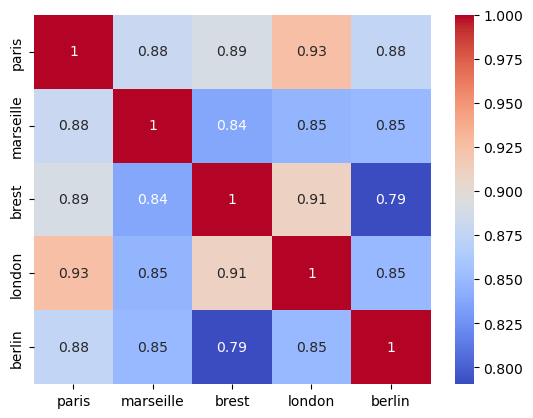

In [30]:
sns.heatmap(variable_datasets["t2m"].corr(), annot=True, cmap="coolwarm")

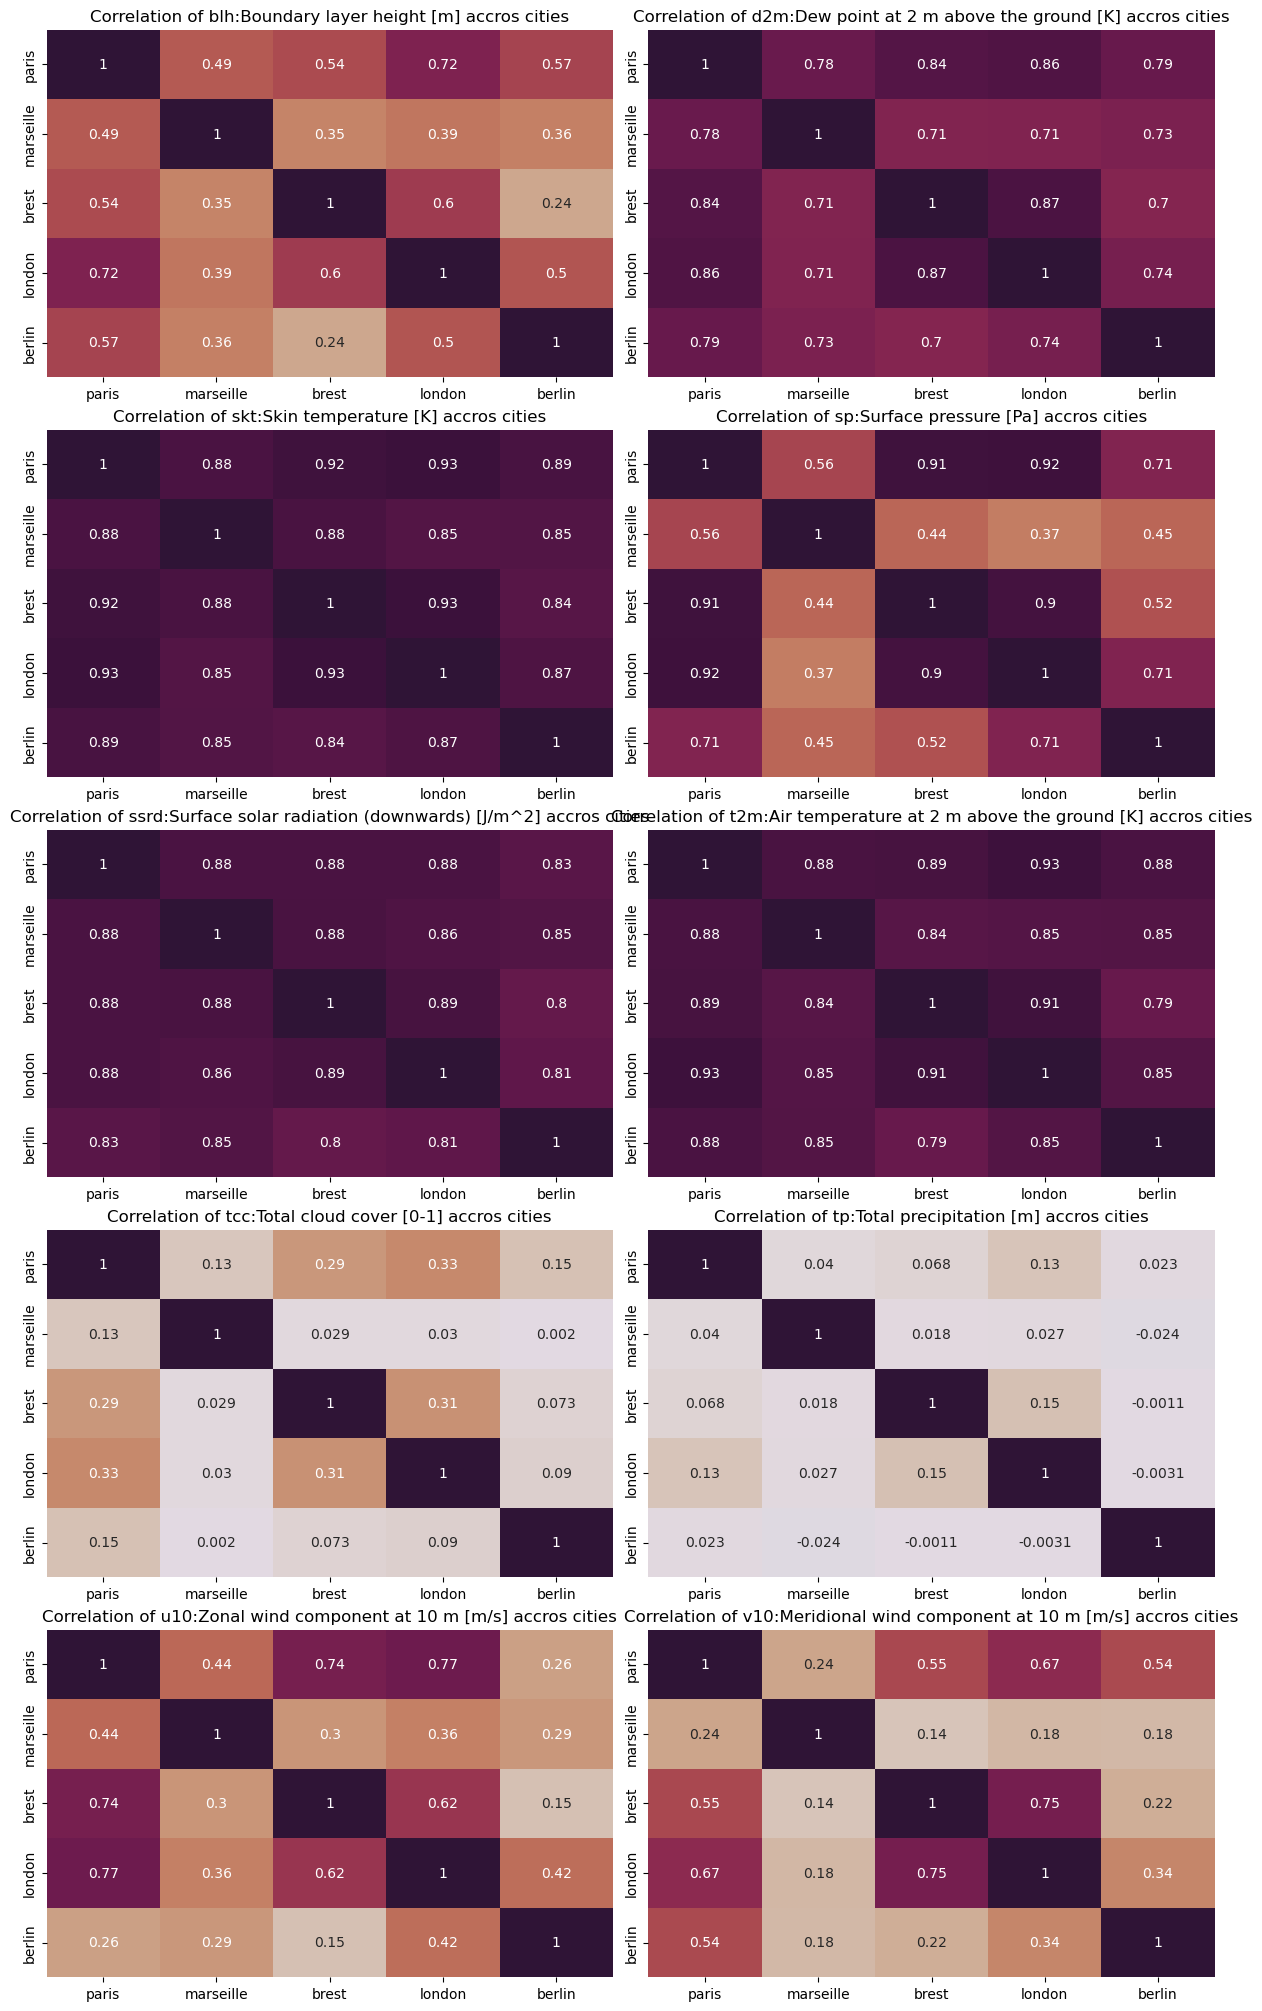

In [31]:
fig, axs = plt.subplots(5, 2, figsize=(12, 20), layout="constrained")
axs = axs.flatten()
for ax, (var, df) in zip(axs, variable_datasets.items()):
    sns.heatmap(
        df.corr(),
        annot=True,
        cmap="twilight_shifted",
        cbar=None,
        vmin=-1,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"Correlation of {var}:{var_legend[var]} accros cities")

> We observe a different correlation between variables accross cities for the following variables:
> - very high for `ssrd`, `t2m`, `skt`, and `d2m`,
> - hig for `u10`, `v10`, `blh` and `sp`.
> - low for `tcc` and `tp`.

> We expect to be able to predict with a high accuracy the correlated variables. But the precipitation and could cover are the most interesting from a human point of view but seems to be hard to predict.

### 2.4 Effect of time

Does the value at Paris at hour H depends on the previous values of other stations ?